In [217]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd
import json
import uuid
import os
import random
import cv2
import math

from scipy import misc
from keras.layers import Convolution2D, Activation, MaxPooling2D, Dropout, Flatten, Dense, ZeroPadding2D, Lambda, ELU, BatchNormalization
from keras.models import Sequential, model_from_json
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

Training data was collected in the Self-Driving Car simulator on Mac OS using a Playstation 3 console controller.

### Recording Measurement class

To simplify accessing each measurement from the original CSV, I've encapsulated each row in a special class.

It serves the following purposes:

  1. Strips whitespace off the left, center, and right camera image paths.
  2. Casts the original absolute path of each camera image to a relative path.
     This adds reassurance the image will load on any computer.
  3. Provides a convenient #is_valid_measurment method which encapsulates pertinent logic to ensure data quality 
     is satisfactory.
  4. Provides convenience getter methods for left, center and camera images. They're essentially designed to 
     lazily instantiate (once) the actual image array at the time the method is invoked.

In [218]:
class RecordingMeasurement:
    """
    A representation of a vehicle's state at a point in time while driving 
    around a track during recording.
    
    Features available are:
    
        left_camera_view   - An image taken by the LEFT camera.
        center_camera_view - An image taken by the CENTER camera.
        right_camera_view  - An image taken by the RIGHT camera.
        steering_angle     - A normalized steering angle in the range -1 to 1.
        speed              - The speed in which the vehicle was traveling at measurement time.
        
        
    This class serves the following purposes:

      1. Provides convenience getter methods for left, center and camera images. 
         In an effort to reduce memory footprint, they're essentially designed 
         to lazily instantiate (once) the actual image array at the time the 
         method is invoked.
      
      2. Strips whitespace off the left, center, and right camera image paths.
      
      3. Casts the original absolute path of each camera image to a relative path.
         This adds reassurance the image will load on any computer.
         
      4. Provides a convenient #is_valid_measurment method which encapsulates 
         pertinent logic to ensure data quality is satisfactory.
         
    """
    def __init__(self, measurement_data):
        self.measurement_data = measurement_data
        
        self.steering_angle = round(float(measurement_data['steering']), 4)
        self.speed = round(float(measurement_data['speed']), 4)
        
        l = measurement_data['left'].strip()
        c = measurement_data['center'].strip()
        r = measurement_data['right'].strip()
        
        # cast absolute path to relative path to be environment agnostic
        l, c, r = [('IMG/' + os.path.split(file_path)[1]) for file_path in (l, c, r)]

        self.left_camera_view_path = l
        self.center_camera_view_path = c
        self.right_camera_view_path = r
    
    def is_valid_measurement(self):
        """
        Return true if the original center image is available to load.
        """
        return os.path.isfile(self.center_camera_view_path)
    
    def left_camera_view(self):
        """
        Lazily instantiates the left camera view image at first call.
        """
        if not hasattr(self, '__left_camera_view'):
            self.__left_camera_view = self.__load_image(self.left_camera_view_path)
        return self.__left_camera_view
    
    def center_camera_view(self):
        """
        Lazily instantiates the center camera view image at first call.
        """
        if not hasattr(self, '__center_camera_view'):
            self.__center_camera_view = self.__load_image(self.center_camera_view_path)
        return self.__center_camera_view
    
    def right_camera_view(self):
        """
        Lazily instantiates the right camera view image at first call.
        """
        if not hasattr(self, '__right_camera_view'):
            self.__right_camera_view = self.__load_image(self.right_camera_view_path)
        return self.__right_camera_view
    
    def __load_image(self, imagepath):
        image_array = None
        if os.path.isfile(imagepath):
            image_array = misc.imread(imagepath)
        else:
            print('File Not Found: {}'.format(imagepath))
        return image_array
    
    def __str__(self):
        results = []
        results.append('Image paths:')
        results.append('')
        results.append('     left_camera_view_path: {}'.format(self.left_camera_view_path))
        results.append('   center_camera_view_path: {}'.format(self.center_camera_view_path))
        results.append('    right_camera_view_path: {}'.format(self.right_camera_view_path))
        results.append('')
        results.append('Additional features:')
        results.append('')
        results.append('   steering_angle: {}'.format(self.steering_angle))
        results.append('            speed: {}'.format(self.speed))
        return '\n'.join(results)

#### Image Preprocessor

Algorithm used to preprocess am image prior to feeding it into the network for training and predicting.

In [219]:
def preprocess_image(image_array, output_shape=(40, 80), colorspace='yuv'):
    """
    Reminder: 
    
    Source image shape is (160, 320, 3)
    
    Our preprocessing algorithm consists of the following steps:
    
      1. Converts BGR to YUV colorspace. 
      
         This allows us to leverage luminance (Y channel - brightness - black and white representation), 
         and chrominance (U and V - blue–luminance and red–luminance differences respectively)
      
      2. Crops top 31.25% portion and bottom 12.5% portion. 
         The entire width of the image is preserved.
         
         This allows the model to generalize better to unseen roadways since we clop 
         artifacts such as trees, buildings, etc. above the horizon. We also clip the 
         hood from the image.
         
      3. Finally, I allow users of this algorithm the ability to specify the shape of the final image via 
         the output_shape argument.
         
         Once I've cropped the image, I resize it to the specified shape using the INTER_AREA 
         interpolation agorithm as it is the best choice to preserve original image features.
         
         See `Scaling` section in OpenCV documentation:
         
         http://docs.opencv.org/trunk/da/d6e/tutorial_py_geometric_transformations.html
    """
    # convert image to another colorspace
    if colorspace == 'yuv':
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2YUV)
    elif colorspace == 'hsv':
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2HSV)
    elif colorspace == 'rgb':
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    

    # [y1:y2, x1:x2]
    # 
    # crops top 31.25% portion and bottom 12.5% portion
    # 
    # The entire width of the image is preserved
    image_array = image_array[50:140, 0:320]
    
    # Let's blur the image to smooth out some of the artifacts
    kernel_size = 5  # Must be an odd number (3, 5, 7...)
    image_array = cv2.GaussianBlur(image_array, (kernel_size, kernel_size), 0)

    # resize image to output_shape
    image_array = cv2.resize(image_array, (output_shape[1], output_shape[0]), interpolation=cv2.INTER_AREA)

    return image_array

### Track 1 Training Dataset class

In [220]:
class Track1Dataset:
    """
    Parses driving_log.csv and constructs training, validation and test datasets corresponding to
    measurements taken at various points in time while recording on track 1.

        * X_train - A set of examples used for learning, that is to fit the parameters [i.e., weights] of the
                    classifier.

        * X_val - A set of examples used to tune the hyperparameters [i.e., architecture, not weights] of a
                       classifier, for example to choose the number of hidden units in a neural network.

        * X_test - A set of examples used only to assess the performance [generalization] of a fully-specified
                   classifier.

        * y_train, y_val, y_test - The steering angle corresponding to their respective X features.
    """

    DRIVING_LOG_PATH = './driving_log.csv'

    def __init__(self, validation_split_percentage=0.2, test_split_percentage=0.05):
        self.X_train = []
        self.X_val = []
        self.X_test = []

        self.y_train = []
        self.y_val = []
        self.y_test = []

        self.dataframe = None
        self.headers = []
        self.__loaded = False

        self.__load(validation_split_percentage=validation_split_percentage,
                    test_split_percentage=test_split_percentage)

        assert self.__loaded == True, 'The dataset was not loaded. Perhaps driving_log.csv is missing.'

    def __load(self, validation_split_percentage, test_split_percentage):
        """
        Splits the training data into a validation and test dataset.

        * X_train - A set of examples used for learning, that is to fit the parameters [i.e., weights] of the classifier.

        * X_val - A set of examples used to tune the hyperparameters [i.e., architecture, not weights] of a
                       classifier, for example to choose the number of hidden units in a neural network.

        * X_test - A set of examples used only to assess the performance [generalization] of a fully-specified
                   classifier.

        * y_train, y_val, y_test - The steering angle corresponding to their respective X features.
        """
        if not self.__loaded:
            X_train, y_train, headers, df = [], [], [], None

            # read in driving_log.csv and construct the
            # initial X_train and y_train before splitting
            # it into validation and testing sets.
            if os.path.isfile(self.DRIVING_LOG_PATH):
                df = pd.read_csv(self.DRIVING_LOG_PATH)
                headers = list(df.columns.values)
                for index, measurement_data in df.iterrows():
                    measurement = RecordingMeasurement(measurement_data=measurement_data)
                    if measurement.is_valid_measurement():
                        X_train.append(measurement)
                        y_train.append(measurement.steering_angle)
                self.__loaded = True

            # generate the validation set
            X_train, X_val, y_train, y_val = train_test_split(
                X_train,
                y_train,
                test_size=validation_split_percentage,
                random_state=0)

            X_train, y_train, X_val, y_val = np.array(X_train), np.array(y_train, dtype=np.float32), \
                                             np.array(X_val), np.array(y_val, dtype=np.float32)

            # generate the test set
            X_train, X_test, y_train, y_test = train_test_split(
                X_train,
                y_train,
                test_size=test_split_percentage,
                random_state=0)

            X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train, dtype=np.float32), \
                                               np.array(X_test), np.array(y_test, dtype=np.float32)

            self.X_train = X_train
            self.X_val = X_val
            self.X_test = X_test

            self.y_train = y_train
            self.y_val = y_val
            self.y_test = y_test

            self.dataframe = df
            self.headers = headers

    def batch_generator(self, X, Y, label, num_epochs, batch_size=32, output_shape=(160, 320), flip_images=True,
                        classifier=None, colorspace='yuv'):
        """
        A custom batch generator with the main goal of reducing memory footprint
        on computers and GPUs with limited memory space.

        Infinitely yields `batch_size` elements from the X and Y datasets.

        During batch iteration, this algorithm randomly flips the image
        and steering angle to reduce bias towards a specific steering angle/direction.
        """
        population = len(X)
        counter = 0
        _index_in_epoch = 0
        _tot_epochs = 0
        batch_size = min(batch_size, population)
        batch_count = int(math.ceil(population / batch_size))

        assert X.shape[0] == Y.shape[0], 'X and Y size must be identical.'

        print('Batch generating against the {} dataset with population {} and shape {}'.format(label, population,
                                                                                               X.shape))
        while True:
            counter += 1
            print('batch gen iter {}'.format(counter))
            for i in range(batch_count):
                start_i = _index_in_epoch
                _index_in_epoch += batch_size
                if _index_in_epoch >= population:
                    # Save the classifier to support manual early stoppage
                    if classifier is not None:
                        classifier.save()
                    print('  sampled entire population. reshuffling deck and resetting all counters.')
                    perm = np.arange(population)
                    np.random.shuffle(perm)
                    X = X[perm]
                    Y = Y[perm]
                    start_i = 0
                    _index_in_epoch = batch_size
                    _tot_epochs += 1
                end_i = _index_in_epoch

                X_batch = []
                y_batch = []

                for j in range(start_i, end_i):
                    steering_angle = Y[j]
                    measurement = X[j]
                    center_image = measurement.center_camera_view()
                    if center_image is not None:
                        image = preprocess_image(center_image, output_shape=output_shape, colorspace=colorspace)

                        # Here I throw in a random image flip to reduce bias towards
                        # a specific direction/steering angle.
                        if flip_images and random.random() > 0.5:
                            X_batch.append(np.fliplr(image))
                            y_batch.append(-steering_angle)
                        else:
                            X_batch.append(image)
                            y_batch.append(steering_angle)

                yield np.array(X_batch), np.array(y_batch)

    def __str__(self):
        results = []
        results.append('{} Stats:'.format(self.__class__.__name__))
        results.append('')
        results.append('  [Headers]')
        results.append('')
        results.append('    {}'.format(self.headers))
        results.append('')
        results.append('')
        results.append('  [Shapes]')
        results.append('')
        results.append('    training features: {}'.format(self.X_train.shape))
        results.append('    training labels: {}'.format(self.y_train.shape))
        results.append('')
        results.append('    validation features: {}'.format(self.X_val.shape))
        results.append('    validation labels: {}'.format(self.y_val.shape))
        results.append('')
        results.append('    test features: {}'.format(self.X_test.shape))
        results.append('    test labels: {}'.format(self.y_test.shape))
        results.append('')
        results.append('  [Dataframe sample]')
        results.append('')
        results.append(str(self.dataframe.head(n=5)))
        return '\n'.join(results)


Instantiates the Track 1 training dataset, prints details about the object then prints the first 5 elements of the dataframe.

In [221]:
dataset = Track1Dataset(validation_split_percentage=0.2, test_split_percentage=0.05)
print(dataset)

Track1Dataset Stats:

  [Headers]

    ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']


  [Shapes]

    training features: (14348,)
    training labels: (14348,)

    validation features: (3776,)
    validation labels: (3776,)

    test features: (756,)
    test labels: (756,)

  [Dataframe sample]

                                   center  \
0  IMG/center_2016_12_01_13_30_48_287.jpg   
1  IMG/center_2016_12_01_13_30_48_404.jpg   
2  IMG/center_2016_12_01_13_31_12_937.jpg   
3  IMG/center_2016_12_01_13_31_13_037.jpg   
4  IMG/center_2016_12_01_13_31_13_177.jpg   

                                    left  \
0   IMG/left_2016_12_01_13_30_48_287.jpg   
1   IMG/left_2016_12_01_13_30_48_404.jpg   
2   IMG/left_2016_12_01_13_31_12_937.jpg   
3   IMG/left_2016_12_01_13_31_13_037.jpg   
4   IMG/left_2016_12_01_13_31_13_177.jpg   

                                    right  steering  throttle  brake  \
0   IMG/right_2016_12_01_13_30_48_287.jpg       0.0       0.0    0.0

#### Feature Plotting

After plotting the steering, throttle, brake, and speed features, we can see that the vast majority of driving was done between 27.5 and 31 MPH.

Furthermore, every feature for brake, steering and throttle was 0 hence the large redish bar at zero for all features.

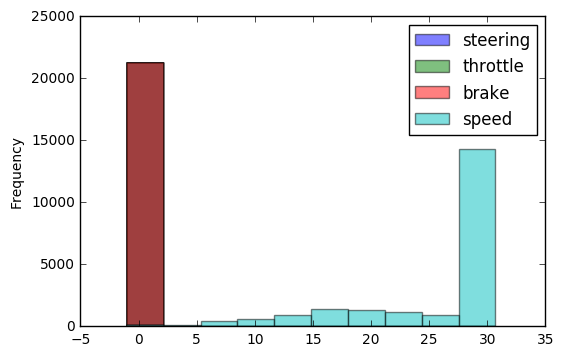

In [222]:
dataset.dataframe.plot.hist(alpha=0.5)

#### Steering Histogram Plot

After plotting a histogram of the steering feature for the entire dataset, we can see that a significant amount more recorded driving was done with the steering wheel between 0.01 and 0.25. We can also observe the majority of recorded driving was done with the steering wheel between -0.25 and 0.25. Very few recorded data went beyond a +/- .5 steering angle.

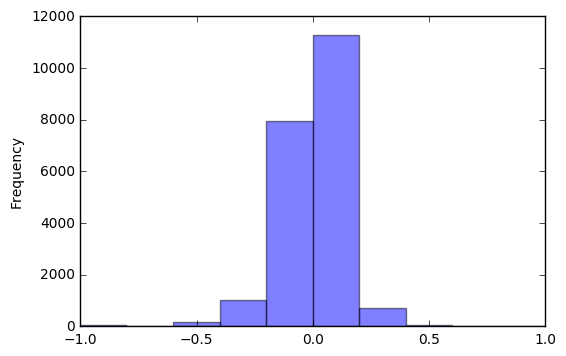

In [223]:
dataset.dataframe['steering'].plot.hist(alpha=0.5)

#### Steering Line Plot

After plotting a standard line graph (honestly, I don't know the official name of this graph) of the steering feature for the entire dataset, the widest curves appear to be dominantly right while smoother, more consistent left curves are observed throughout the entire recording session.

Furthermore, I postulate the abrupt right turn spikes with large gaps are indicative of recovery training from the right line moving towards the center of the lane.

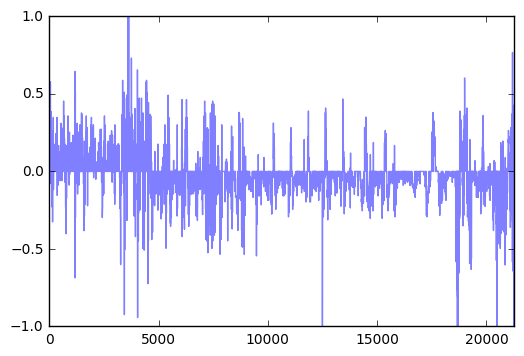

In [224]:
dataset.dataframe['steering'].plot(alpha=0.5)

#### Explore the features

Here I sample the 0th training feature and print some statistics about the 0th RecordingMeasurement.

In [225]:
print('Center camera view shape:\n\n{}\n'.format(dataset.X_train[0].center_camera_view().shape))
print(dataset.X_train[0])

Center camera view shape:

(160, 320, 3)

Image paths:

     left_camera_view_path: IMG/left_2016_12_01_13_34_10_297.jpg
   center_camera_view_path: IMG/center_2016_12_01_13_34_10_297.jpg
    right_camera_view_path: IMG/right_2016_12_01_13_34_10_297.jpg

Additional features:

   steering_angle: 0.0
            speed: 30.1866


#### Visualize batch features

Here I've plotted the first image from all three datasets.

I've plotted the original image in the YUV colorspace as well as each channel Y, U and V.

Between RGB, HSV and YUV, the YUV colorspace captured the most intuitive representation of steering angle to image pixels representing a curved road.

##### Plot of original source images at various steering angles

Image paths:

     left_camera_view_path: IMG/left_2016_12_01_13_38_42_894.jpg
   center_camera_view_path: IMG/center_2016_12_01_13_38_42_894.jpg
    right_camera_view_path: IMG/right_2016_12_01_13_38_42_894.jpg

Additional features:

   steering_angle: 1.0
            speed: 20.1579


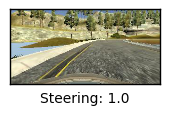

In [226]:
fig = plt.figure()
fig.subplots_adjust(hspace=1., wspace=0.05)

SAMPLE_ANGLE = 0.5

df = dataset.dataframe
samples = pd.DataFrame(df[(df.steering > SAMPLE_ANGLE)].sample(n=3)).iterrows()

idx, measurement_data = next(samples)
measurement = RecordingMeasurement(measurement_data)
print(measurement)

# plot first training image
a = fig.add_subplot(1,3,1)
plot_image(a, '', measurement.center_camera_view(), measurement.steering_angle)

Image paths:

     left_camera_view_path: IMG/left_2016_12_01_13_38_42_894.jpg
   center_camera_view_path: IMG/center_2016_12_01_13_38_42_894.jpg
    right_camera_view_path: IMG/right_2016_12_01_13_38_42_894.jpg

Additional features:

   steering_angle: 1.0
            speed: 20.1579


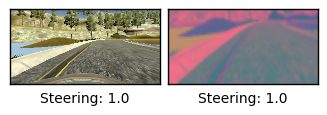

In [230]:
fig = plt.figure()
fig.subplots_adjust(hspace=1., wspace=0.05)

SAMPLE_ANGLE = 0.75

df = dataset.dataframe
samples = pd.DataFrame(df[(df.steering > SAMPLE_ANGLE)].sample(n=3)).iterrows()

idx, measurement_data = next(samples)
measurement = RecordingMeasurement(measurement_data)
print(measurement)

# plot first training image
a = fig.add_subplot(1,3,1)
plot_image(a, '', measurement.center_camera_view(), measurement.steering_angle)

# plot first training image
a = fig.add_subplot(1,3,2)
plot_image(a, '', preprocess_image(measurement.center_camera_view()), measurement.steering_angle)

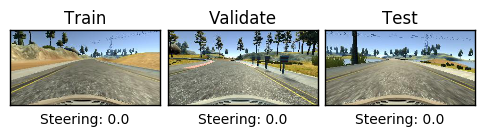

In [199]:
fig = plt.figure()
fig.subplots_adjust(hspace=1., wspace=0.05)

# plot first training image
a=fig.add_subplot(1,3,1)
plot_image(a, 'Train', mpimg.imread(dataset.X_train[0].center_camera_view_path), dataset.y_train[0])

# plot first validation image
a=fig.add_subplot(1,3,2)
plot_image(a, 'Validate', mpimg.imread(dataset.X_val[0].center_camera_view_path), dataset.y_val[0])

# plot first test image
a=fig.add_subplot(1,3,3)
plot_image(a, 'Test', mpimg.imread(dataset.X_test[0].center_camera_view_path), dataset.y_test[0])

#### Plot of preprocessed images from batch generators

Creates a train, validate and test generator yielding only a single image.

Notice how I am specifying the YUV colorspace. This triggers the image preprocessor to convert the original RGB image into the YUV colorspace.

This essentially simulates what Keras does under the covers whenever it requests the next batch of features to train against.

In [200]:
output_shape = (40, 80, 3)
train_generator = dataset.batch_generator(
    colorspace='yuv',
    X=dataset.X_train[0:1],
    Y=dataset.y_train[0:1],
    output_shape=output_shape,
    label='training batch feature exploration', 
    num_epochs=1, 
    batch_size=1
)

val_generator = dataset.batch_generator(
    colorspace='yuv',
    X=dataset.X_val[0:1],
    Y=dataset.y_val[0:1],
    output_shape=output_shape,
    label='validation batch feature exploration', 
    num_epochs=1, 
    batch_size=1
)

test_generator = dataset.batch_generator(
    colorspace='yuv',
    X=dataset.X_test[0:1],
    Y=dataset.y_test[0:1],
    output_shape=output_shape,
    label='test batch feature exploration', 
    num_epochs=1, 
    batch_size=1
)

#### Convenience method to plot an image, title, and steering angle

In [201]:
def plot_image(a, title, img, steering_angle):
    a.get_xaxis().set_ticks([])
    a.get_yaxis().set_ticks([])
    a.set_title(title)
    a.set_xlabel('Steering: {}'.format(steering_angle))
    return plt.imshow(img)

#### Plots the image which is the actual non-normalized feature fed into the network for training/prediction.

Batch generating against the training batch feature exploration dataset with population 1 and shape (1,)
batch gen iter 1
  sampled entire population. reshuffling deck and resetting all counters.
Batch generating against the validation batch feature exploration dataset with population 1 and shape (1,)
batch gen iter 1
  sampled entire population. reshuffling deck and resetting all counters.
Batch generating against the test batch feature exploration dataset with population 1 and shape (1,)
batch gen iter 1
  sampled entire population. reshuffling deck and resetting all counters.


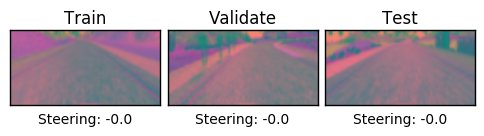

In [202]:
X_train_batch, y_train_batch = next(train_generator)
X_val_batch, y_val_batch = next(val_generator)
X_test_batch, y_test_batch = next(test_generator)

fig = plt.figure()
fig.subplots_adjust(hspace=1., wspace=0.05)

# plot first training image
a=fig.add_subplot(1,3,1)
plot_image(a, 'Train', X_train_batch[0], y_train_batch[0])

# plot first validation image
a=fig.add_subplot(1,3,2)
plot_image(a, 'Validate', X_val_batch[0], y_val_batch[0])

# plot first test image
a=fig.add_subplot(1,3,3)
plot_image(a, 'Test', X_test_batch[0], y_test_batch[0])

#### The 'Y' channel (brightness)

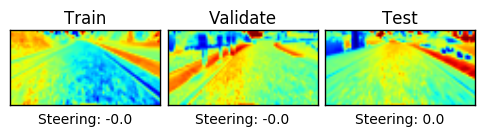

In [125]:
fig = plt.figure()
fig.subplots_adjust(hspace=1., wspace=0.05)

a=fig.add_subplot(2,3,1)
plot_image(a, 'Train', X_train_batch[0][:,:,0], y_train_batch[0])

# plot first validation image
a=fig.add_subplot(2,3,2)
plot_image(a, 'Validate', X_val_batch[0][:,:,0], y_val_batch[0])

# plot first test image
a=fig.add_subplot(2,3,3)
plot_image(a, 'Test', X_test_batch[0][:,:,0], y_test_batch[0])

#### The 'U' channel (blue–luminance)

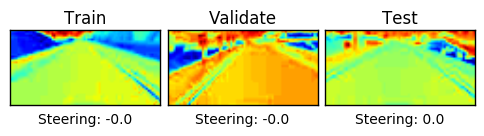

In [126]:
fig = plt.figure()
fig.subplots_adjust(hspace=1., wspace=0.05)

a=fig.add_subplot(2,3,1)
plot_image(a, 'Train', X_train_batch[0][:,:,1], y_train_batch[0])

# plot first validation image
a=fig.add_subplot(2,3,2)
plot_image(a, 'Validate', X_val_batch[0][:,:,1], y_val_batch[0])

# plot first test image
a=fig.add_subplot(2,3,3)
plot_image(a, 'Test', X_test_batch[0][:,:,1], y_test_batch[0])

#### The 'V' channel (red–luminance)

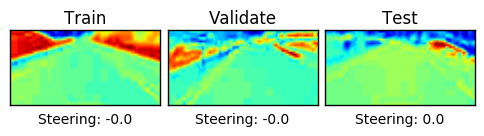

In [127]:
fig = plt.figure()
fig.subplots_adjust(hspace=1., wspace=0.05)

a=fig.add_subplot(2,3,1)
plot_image(a, 'Train', X_train_batch[0][:,:,2], y_train_batch[0])

# plot first validation image
a=fig.add_subplot(2,3,2)
plot_image(a, 'Validate', X_val_batch[0][:,:,2], y_val_batch[0])

# plot first test image
a=fig.add_subplot(2,3,3)
plot_image(a, 'Test', X_test_batch[0][:,:,2], y_test_batch[0])

#### Network Architecture

BaseNetwork is the base class for all network implementations. It contains the necessary plumbing to save trained network data, load previously trained model and weights, and implements the abstract *#fit* and *#build_model* methods which all sub classes must implement.

In [128]:
class BaseNetwork:
    WEIGHTS_FILE_NAME = 'model.h5'
    MODEL_FILE_NAME = 'model.json'

    def __init__(self):
        self.uuid = uuid.uuid4()
        self.model = None
        self.weights = None

    def fit(self, model, batch_generator, X_train, y_train, X_val, y_val, nb_epoch=2, batch_size=32,
            samples_per_epoch=None, output_shape=(160, 320, 3)):
        raise NotImplementedError

    def build_model(self, input_shape, output_shape, learning_rate=0.001, dropout_prob=0.1, activation='relu'):
        raise NotImplementedError

    def save(self):
        print('Saved {} model.'.format(self.__class__.__name__))
        self.__persist()

    def restore(self):
        model = None
        if os.path.exists(self.MODEL_FILE_NAME):
            with open(self.MODEL_FILE_NAME, 'r') as jfile:
                the_json = json.load(jfile)
                print(json.loads(the_json))
                model = model_from_json(the_json)
            if os.path.exists(self.WEIGHTS_FILE_NAME):
                model.load_weights(self.WEIGHTS_FILE_NAME)
        return model

    def __persist(self):
        save_dir = os.path.join(os.path.dirname(__file__))
        weights_save_path = os.path.join(save_dir, self.WEIGHTS_FILE_NAME)
        model_save_path = os.path.join(save_dir, self.MODEL_FILE_NAME)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        self.model.save_weights(weights_save_path)
        with open(model_save_path, 'w') as outfile:
            json.dump(self.model.to_json(), outfile)

    def __str__(self):
        results = []
        if self.model is not None:
            results.append(self.model.summary())
        return '\n'.join(results)


#### Track1
##### A subclass of BaseNetwork

The Track1 network architecture I chose was a simple 4-layer convolutional neural network with 4 fully connected layers along with 10% dropout after flattening the data as well as after the first FC layer.

I chose the Adam optimizer after first analyzing and comparing the [various Keras optimizers](). 

My entire network is essentially inspired by the original original [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8) achademic paper, particlarly _6.3 EXPERIMENT: CONVOLUTIONAL NEURAL NETWORKS_.

> **6.3 EXPERIMENT: CONVOLUTIONAL NEURAL NETWORKS**

> Convolutional neural networks (CNNs) with several layers of convolution, pooling and non-linear
units have shown considerable success in computer vision tasks. Unlike most fully connected neural
nets, weight sharing in CNNs results in vastly different gradients in different layers. A smaller
learning rate for the convolution layers is often used in practice when applying SGD. We show the
effectiveness of Adam in deep CNNs. Our CNN architecture has three alternating stages of 5x5
convolution filters and 3x3 max pooling with stride of 2 that are followed by a fully connected layer
of 1000 rectified linear hidden units (ReLU’s). The input image are pre-processed by whitening, and dropout noise is applied to the input layer and fully connected layer. The minibatch size is also set
to 128 similar to previous experiments.

> Interestingly, although both Adam and Adagrad make rapid progress lowering the cost in the initial
stage of the training, shown in Figure 3 (left), Adam and SGD eventually converge considerably
faster than Adagrad for CNNs shown in Figure 3 (right). We notice the second moment estimate vbt
vanishes to zeros after a few epochs and is dominated by the  in algorithm 1. The second moment
estimate is therefore a poor approximation to the geometry of the cost function in CNNs comparing
to fully connected network from Section 6.2. Whereas, reducing the minibatch variance through
the first moment is more important in CNNs and contributes to the speed-up. As a result, Adagrad
converges much slower than others in this particular experiment. Though Adam shows marginal
improvement over SGD with momentum, it adapts learning rate scale for different layers instead of
hand picking manually as in SGD.

In [132]:
class Track1(BaseNetwork):
    def fit(self, model, batch_generator, X_train, y_train, X_val, y_val, nb_epoch=2, batch_size=32,
            samples_per_epoch=None, output_shape=(40, 80, 3)):
        # Keras throws an exception if we specify a batch generator
        # for an empty validation dataset.
        validation_data = None
        if len(X_val) > 0:
            validation_data = batch_generator(
                X=X_val,
                Y=y_val,
                label='validation set',
                num_epochs=nb_epoch,
                batch_size=batch_size,
                output_shape=output_shape
            )

        # Fit the model leveraging the custom
        # batch generator baked into the
        # dataset itself.
        history = model.fit_generator(
            batch_generator(
                X=X_train,
                Y=y_train,
                label='train set',
                num_epochs=nb_epoch,
                batch_size=batch_size,
                output_shape=output_shape,
                classifier=self
            ),
            nb_epoch=nb_epoch,
            samples_per_epoch=len(X_train),
            nb_val_samples=len(X_val),
            verbose=2,
            validation_data=validation_data
        )

        print(history.history)
        self.save()

    def build_model(self, input_shape, output_shape, learning_rate=0.001, dropout_prob=0.1, activation='relu',
                    use_weights=False):
        """
        Inital zero-mean normalization input layer.
        A 4-layer deep neural network with 4 fully connected layers at the top.
        ReLU activation used on each convolution layer.
        Dropout of 10% (default) used after initially flattening after convolution layers.
        Dropout of 10% (default) used after first fully connected layer.

        Adam optimizer with 0.001 learning rate (default) used in this network.
        Mean squared error loss function was used since this is a regression problem and MSE is
        quite common and robust for regression analysis.
        """
        model = None
        if use_weights:
            model = self.restore()
        if model is None:
            model = Sequential()
            model.add(Lambda(lambda x: x / 255 - 0.5,
                             input_shape=input_shape,
                             output_shape=output_shape))
            model.add(Convolution2D(24, 5, 5, border_mode='valid', activation=activation))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Convolution2D(36, 5, 5, border_mode='valid', activation=activation))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Convolution2D(48, 5, 5, border_mode='same', activation=activation))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Convolution2D(64, 3, 3, border_mode='same', activation=activation))
            model.add(Flatten())
            model.add(Dropout(dropout_prob))
            model.add(Dense(1024, activation=activation))
            model.add(Dropout(dropout_prob))
            model.add(Dense(100, activation=activation))
            model.add(Dense(50, activation=activation))
            model.add(Dense(10, activation=activation))
            model.add(Dense(1, init='normal'))

        optimizer = Adam(lr=learning_rate)
        model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
        self.model = model
        model.summary()
        return model


#### Instantiate the classifier

In [133]:
output_shape=(40, 80, 3)

clf = Track1()
model = clf.build_model(
    input_shape=output_shape, 
    output_shape=output_shape, 
    learning_rate=0.001, 
    dropout_prob=0.1, 
    activation='relu'
)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 40, 80, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 36, 76, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 18, 38, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 34, 36)    21636       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

#### Train the network

In [134]:
if False:
    clf.fit(
        model, 
        dataset, 
        nb_epoch=2, 
        batch_size=32
    )